# How to predict <span style="color:red">sequence data</span>?
![](./imgs/seq_data.JPG)
<br>
<br>

# ★ A popular solution: <span style="color:blue">Recurrent Neural Network</span>
![](./imgs/RNN_1.JPG)
<br>
<span style="color:gray">
Source: colah's blog - <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>
</span>
<br>
<hr>
<br>
## More details about the structure
![](./imgs/RNN_2.JPG)
<br>
<br>
## Simplify the structure
![](./imgs/RNN_3.JPG)

<span style="color:gray">
Source: colah's blog - <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>
</span>
<br>
<hr>
<br>


## However, *<span style="color:red">it is hard to learn the long-term dependencies</span>* <a href="./Data/tnn-94-gradient.pdf">(Bengio, et al., 1994)</a>.
![](./imgs/RNN_4.JPG)

# <span style="color:blue">★ A new solution (a variant of RNN):</span> <span style="color:red">L</span>ong <span style="color:red">S</span>hort-<span style="color:red">T</span>erm <span style="color:red">M</span>emory
<br>
<br>
![](./imgs/LSTM_1.JPG)

<span style="color:gray">
Source: colah's blog - <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>
</span>
<br>
<hr>
<br>
## LSTM v.s. RNN
<br>
![](./imgs/LSTM_2.JPG)
<br>
<hr>
<br>
## <span style="color:red">LSTM Mechanisms</span>
<br>
![](./imgs/LSTM_3.JPG)
<br>
<hr>
<br>
## <span style="color:red">● States</span>
<br>
![](./imgs/LSTM_4.JPG)
<br>
<hr>
<br>
## <span style="color:red">● Forget gate</span>
<br>
![](./imgs/LSTM_5.JPG)
<br>
<hr>
<br>
## <span style="color:red">● Input gate</span>
<br>
![](./imgs/LSTM_6.JPG)
<br>
<hr>
<br>
## <span style="color:red">● Output gate</span>
<br>
![](./imgs/LSTM_7.JPG)
<br>
<hr>
<br>

# <span style="color:red">LSTM in TensorFlow</span>
<br>
![](./imgs/LSTM_func.JPG)
<br>
- tf.contrib.rnn.BasicLSTMCell()
- tf.contrib.rnn.static_rnn()

In [1]:
# tf.contrib.rnn.BasicLSTMCell(hidden layer units number)
# tf.contrib.rnn.static_rnn(rnn cell, inputs, initial state) --> return (outputs, final states)


## - Mission: predict the sine wave (sequence to sequence case)
<br>
![](./imgs/LSTM_sin.JPG)
<br>
### An example of sequence to sequence case
![](./imgs/LSTM_seq2seq.JPG)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Training data

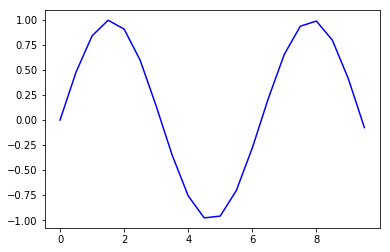

In [3]:
t = np.arange(0, 10, 0.5)
y_real = np.sin(t).reshape([-1, 1])

plt.plot(t, y_real, 'b')
plt.show()

In [4]:
y_real.shape

(20, 1)

## RNN

- Functions of weight and bias

In [5]:
def _weight(shape):
    initial = tf.truncated_normal(dtype=tf.float32, stddev=.5, shape=shape)
    return tf.Variable(initial)
def _bias(shape):
    initial = tf.constant(dtype=tf.float32, value=.5, shape=shape)
    return tf.Variable(initial)

- 5 encoder inputs and 5 decoder outputs

In [6]:
n_input = 1 # input data dimension
n_hiddens = 64 # hidden layer units number
n_output = 1 # output data dimension
enc_len = 5 # encoder length
dec_len = 5 # decoder length

- Encoder inputs and outputs
![](./imgs/LSTM_seq2seq_2.JPG)

In [7]:
# LSTM cell
LSTM = tf.contrib.rnn.BasicLSTMCell(n_hiddens)

# encoder input
x = [tf.placeholder(tf.float32, shape=[None, n_input], name='input') for i in range(enc_len)]
w_enc = _weight([n_input, n_hiddens])
b_enc = _bias([n_hiddens])
encoder_input = [tf.add(tf.matmul(x[i], w_enc), b_enc) for i in range(enc_len)]

# encoder output
with tf.variable_scope('enc'):
    _, encoder_state = tf.contrib.rnn.static_rnn(cell=LSTM,
                                                 inputs=encoder_input,
                                                 dtype=tf.float32)

- decoder input and output
![](./imgs/LSTM_seq2seq_3.JPG)

In [8]:
# predicting target 
y = [tf.placeholder(tf.float32, shape=[None, n_output], name='answer') for i in range(dec_len)]

# decoder input : <start> + output target (except the last one)
decoder_input = [tf.zeros_like(y[0], dtype=tf.float32)] + y[0:-1]
w_dec = _weight([n_input, n_hiddens])
b_dec = _bias([n_hiddens])
decoder_input = [tf.add(tf.matmul(decoder_input[i], w_dec), b_dec) for i in range(dec_len)]

# decoder output
with tf.variable_scope('dec'):
    decoder_outputs, _ = tf.contrib.rnn.static_rnn(cell=LSTM,
                                                   inputs=decoder_input,
                                                   initial_state=encoder_state,
                                                   dtype=tf.float32)

In [9]:
# outputs generate
w_out = _weight([n_hiddens, n_output])
b_out = _bias([n_output])
preds = [tf.add(tf.matmul(decoder_outputs[i], w_out), b_out, name='pred') for i in range(dec_len)]

- Loss and optimizer

In [10]:
output_loss = 0
for _y, _Y in zip(preds, y):
    output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

l_r = 1e-3
update_step = tf.train.AdamOptimizer(l_r).minimize(output_loss)

- Evaluation function (plotting)

In [11]:
def evaluate(sess):
    batch_x = [y_real[i].reshape([-1, 1]) for i in range(5)]
    batch_y = [y_real[i+5].reshape([-1, 1]) for i in range(5)]
    feed_dict = {x[j]:batch_x[j] for j in range(enc_len)}
    feed_dict.update({y[j]:batch_y[j] for j in range(enc_len)})
    y_pred1 = np.array(sess.run(preds, feed_dict=feed_dict))

    batch_x = y_pred1
    batch_y = [y_real[i+10].reshape([-1, 1]) for i in range(5)]
    feed_dict = {x[j]:batch_x[j] for j in range(enc_len)}
    feed_dict.update({y[j]:batch_y[j] for j in range(enc_len)})
    y_pred2 = np.array(sess.run(preds, feed_dict=feed_dict))

    y_pred = np.vstack([y_pred1, y_pred2]).reshape([-1])
    plt.plot(np.arange(15), y_real[0:15], 'b')
    plt.plot(np.arange(11)+4, [y_real[4]]+list(y_pred), '--r')
    plt.legend(['Real', 'Prediction'])
    
def evaluate2(sess):
    batch_x = [y_real[i+3].reshape([-1, 1]) for i in range(5)]
    batch_y = [y_real[i+5+3].reshape([-1, 1]) for i in range(5)]
    feed_dict = {x[j]:batch_x[j] for j in range(enc_len)}
    feed_dict.update({y[j]:batch_y[j] for j in range(enc_len)})
    y_pred1 = np.array(sess.run(preds, feed_dict=feed_dict))

    batch_x = y_pred1
    batch_y = [y_real[i+10+3].reshape([-1, 1]) for i in range(5)]
    feed_dict = {x[j]:batch_x[j] for j in range(enc_len)}
    feed_dict.update({y[j]:batch_y[j] for j in range(enc_len)})
    y_pred2 = np.array(sess.run(preds, feed_dict=feed_dict))

    y_pred = np.vstack([y_pred1, y_pred2]).reshape([-1])
    plt.plot(np.arange(15), y_real[0+3:15+3], 'b')
    plt.plot(np.arange(11)+4, [y_real[4+3]]+list(y_pred), '--r')
    plt.legend(['Real', 'Prediction']) 
    
def evaluate3(sess):
    batch_x = [y_real[i+5].reshape([-1, 1]) for i in range(5)]
    batch_y = [y_real[i+5+5].reshape([-1, 1]) for i in range(5)]
    feed_dict = {x[j]:batch_x[j] for j in range(enc_len)}
    feed_dict.update({y[j]:batch_y[j] for j in range(enc_len)})
    y_pred1 = np.array(sess.run(preds, feed_dict=feed_dict))

    batch_x = y_pred1
    batch_y = [y_real[i+10+5].reshape([-1, 1]) for i in range(5)]
    feed_dict = {x[j]:batch_x[j] for j in range(enc_len)}
    feed_dict.update({y[j]:batch_y[j] for j in range(enc_len)})
    y_pred2 = np.array(sess.run(preds, feed_dict=feed_dict))

    y_pred = np.vstack([y_pred1, y_pred2]).reshape([-1])
    plt.plot(np.arange(15), y_real[0+5:15+5], 'b')
    plt.plot(np.arange(11)+4, [y_real[4+5]]+list(y_pred), '--r')
    plt.legend(['Real', 'Prediction'])

- Training

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
epoch = 100
batch_size = 5
loss_list = list()

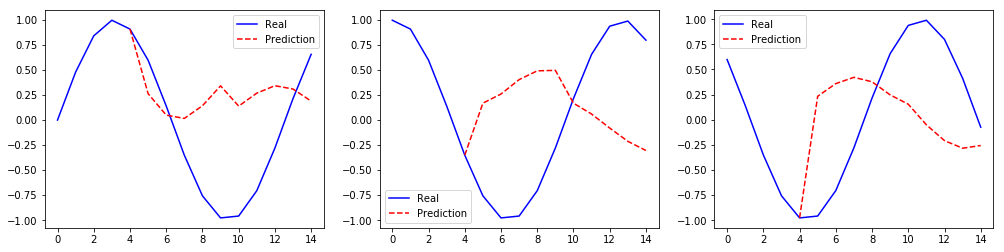

In [13]:
# Initial prediction
plt.figure(figsize=[17, 4])
plt.subplot(131)
evaluate(sess)
plt.subplot(132)
evaluate2(sess)
plt.subplot(133)
evaluate3(sess)
plt.show()

Epoch: 10 , loss: 1.22853


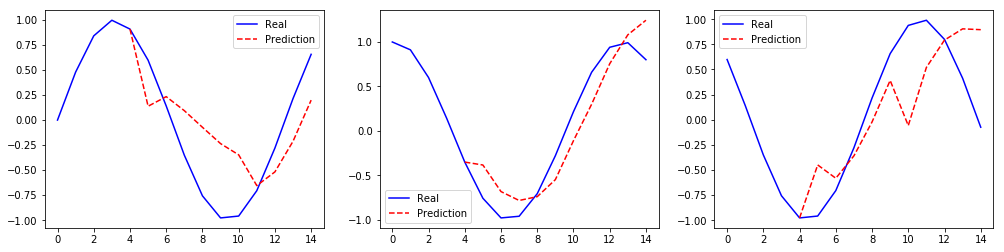

-------------------------------------------------------------------
Epoch: 20 , loss: 0.369636


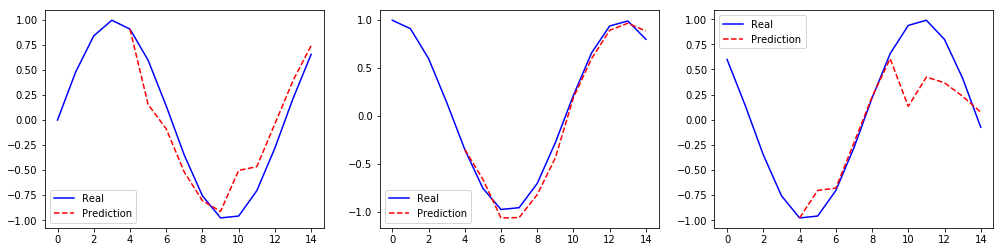

-------------------------------------------------------------------
Epoch: 30 , loss: 0.107369


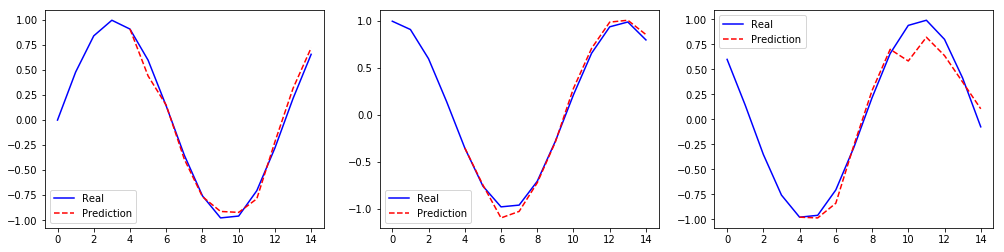

-------------------------------------------------------------------
Epoch: 40 , loss: 0.039719


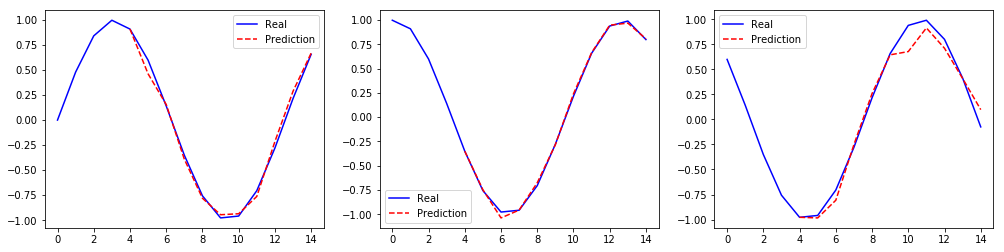

-------------------------------------------------------------------
Epoch: 50 , loss: 0.0243069


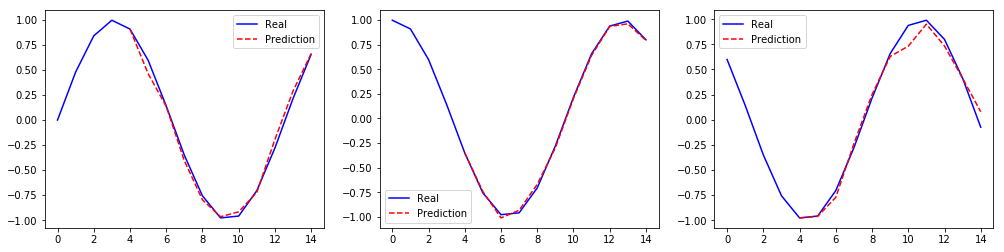

-------------------------------------------------------------------
Epoch: 60 , loss: 0.0167261


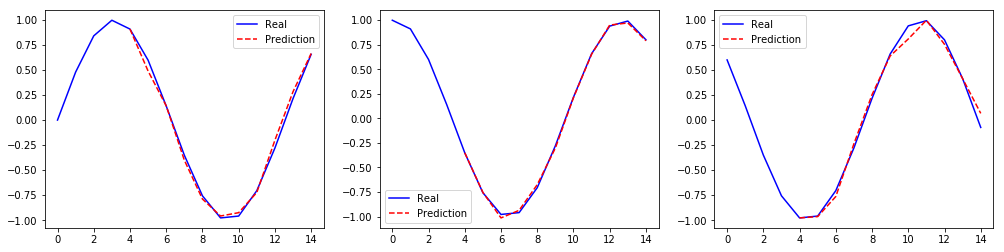

-------------------------------------------------------------------
Epoch: 70 , loss: 0.0127604


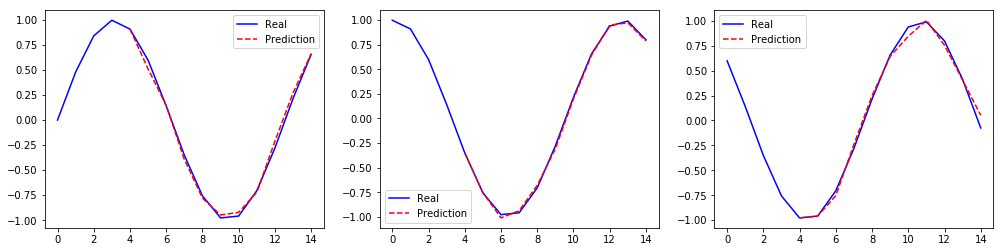

-------------------------------------------------------------------
Epoch: 80 , loss: 0.0100782


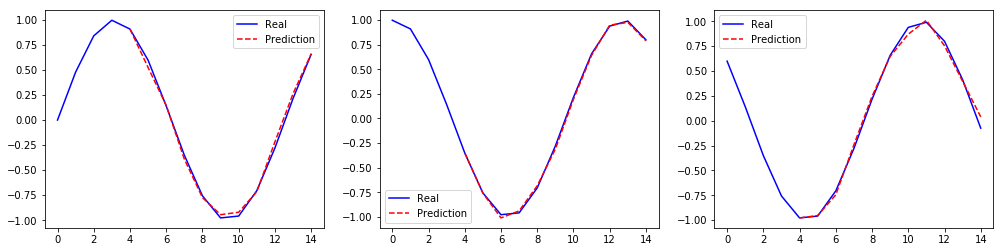

-------------------------------------------------------------------
Epoch: 90 , loss: 0.00813295


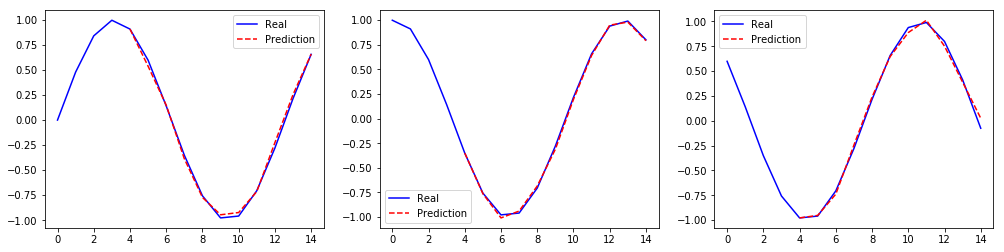

-------------------------------------------------------------------
Epoch: 100 , loss: 0.0067206


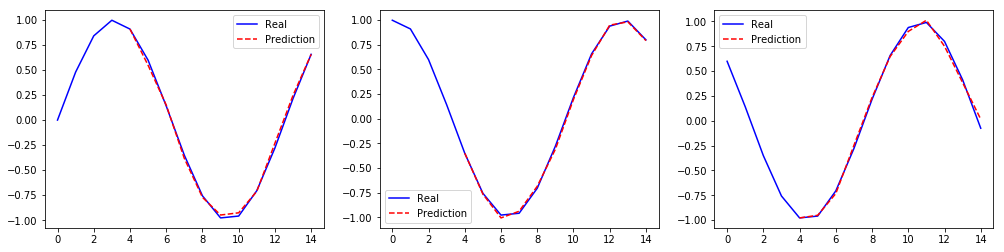

-------------------------------------------------------------------


In [14]:
for epo in range(epoch):
    for i in range(2):
        batch_x = [y_real[i*batch_size+j:i*batch_size+batch_size+j].reshape([-1, 1]) for j in range(batch_size)]
        batch_y = [y_real[i*batch_size+5+j:i*batch_size+batch_size+5+j].reshape([-1, 1]) for j in range(batch_size)]
        feed_dict = {x[j]:batch_x[j] for j in range(len(x))}
        feed_dict.update({y[j]:batch_y[j] for j in range(len(y))})
        _, l = sess.run([update_step, output_loss], feed_dict=feed_dict)
        loss_list.append(l)
    if (epo+1)%10 == 0:
        print('Epoch:', epo+1, ', loss:', l)
        plt.figure(figsize=[17, 4])
        plt.subplot(131)
        evaluate(sess)
        plt.subplot(132)
        evaluate2(sess)
        plt.subplot(133)
        evaluate3(sess)
        plt.show()
        print('-------------------------------------------------------------------')

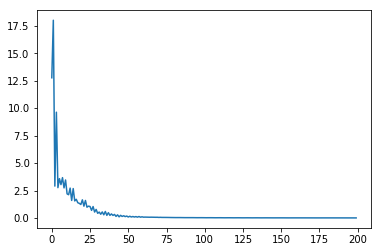

In [15]:
plt.plot(np.arange(len(loss_list)), loss_list)
plt.show()

## Reference:
- <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTMs</a>
- <a href="https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn">TensorFlow dynamic_rnn</a>
- <a href="https://github.com/guillaume-chevalier/seq2seq-signal-prediction">Github : seq2seq-signal-prediction</a>

## Extending:
- <a href="https://www.tensorflow.org/tutorials/seq2seq">TensorFlow seq2seq model (translation case)</a>